# Task 4

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse 

G = pd.read_pickle('bigger_graph.pickle')
G

Number of nodes: 2767
Number of edges: 229384
Average degree: 165.79978315865557
Is the graph connected? True
Number of connected components: 1


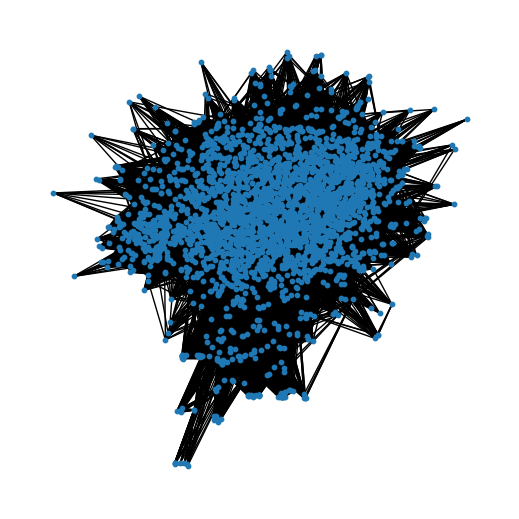

In [2]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
degrees = [G.degree(n) for n in G.nodes()]
print(f"Average degree: {sum(degrees) / len(degrees)}")
print(f"Is the graph connected? {nx.is_connected(G)}")
print(f"Number of connected components: {nx.number_connected_components(G)}")

plt.figure(figsize=(5, 5)) 
pos = nx.spring_layout(G)
nx.draw(G, pos , with_labels=False, node_size=10)
plt.show()

In [3]:
def recommend_songs_weighted(graph, input_song, num_recommendations=5):
    recommended_songs = []

    if input_song in graph.nodes:
        current_song = input_song
        visited = set([current_song])
        
        while len(recommended_songs) < num_recommendations:
            neighbors = list(graph[current_song])
            neighbor_weights = [(neighbor, graph.edges[current_song, neighbor]['weight']) for neighbor in neighbors if neighbor not in visited]
            
            if not neighbor_weights:
                break
            
            # Sort neighbors by edge weights in descending order
            neighbor_weights.sort(key=lambda x: x[1], reverse=True)
            
            next_song = neighbor_weights[0][0]
            recommended_songs.append((next_song, neighbor_weights[0][1]))
            visited.add(next_song)
            current_song = next_song
        
        return recommended_songs
    else:
        print("Input song not found in the graph.")
        return None


input_song = "spotify:track:6yHkPtl6UQ7RjtJLBPzbJw"  
num_recommendations = 5 
recommended_songs_weighted = recommend_songs_weighted(G, input_song, num_recommendations)
print("Recommended songs:")
for song in recommended_songs_weighted:
    print(song)

Recommended songs:
('spotify:track:0dA2Mk56wEzDgegdC6R17g', 3)
('spotify:track:0CcQNd8CINkwQfe1RDtGV6', 5)
('spotify:track:152lZdxL1OR0ZMW6KquMif', 4)
('spotify:track:3kxfsdsCpFgN412fpnW85Y', 8)
('spotify:track:7hDc8b7IXETo14hHIHdnhd', 6)


In [4]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import time
import pandas as pd

SPOTIPY_CLIENT_ID = '2c79005a25ff450fa2c58921fbfe370f'
SPOTIPY_CLIENT_SECRET = 'e6576447735343e28e391f30a16a9204'
SPOTIPY_REDIRECT_URI = 'http://localhost:3000'

# Define the scope of access
scope = "user-read-private"

# an instance of SpotifyOAuth
oauth = SpotifyOAuth(client_id=SPOTIPY_CLIENT_ID,
                     client_secret=SPOTIPY_CLIENT_SECRET,
                     redirect_uri=SPOTIPY_REDIRECT_URI,
                     scope=scope)

# an instance of Spotipy with the OAuth handler
sp = spotipy.Spotify(auth_manager=oauth)

G = pd.read_pickle('bigger_graph.pickle')

#the nodes in the graph G are Spotify track IDs
for node in G.nodes():
    # Getting track information from Spotify API
    track_info = sp.track(node)
    audio_features = sp.audio_features(node)[0]

    properties = {
        'name': track_info['name'],
        'popularity': track_info['popularity'],
        'duration_ms': track_info['duration_ms'],
        'danceability': audio_features['danceability'],
        'energy': audio_features['energy'],
        'key': audio_features['key'],
        'loudness': audio_features['loudness'],
        'mode': audio_features['mode'],
        'speechiness': audio_features['speechiness'],
        'acousticness': audio_features['acousticness'],
        'instrumentalness': audio_features['instrumentalness'],
        'liveness': audio_features['liveness'],
        'valence': audio_features['valence'],
        'tempo': audio_features['tempo']
    }
    
    # Add these properties to the node in the graph
    G.nodes[node]['properties'] = properties

    time.sleep(0.1)


Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=0Nk7bSn0MItonkR0GNs3mj:
 Max Retries, reason: too many 429 error responses

In [ ]:
import numpy as np
import spotipy.exceptions

# Define the features you want to keep
features_to_keep = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness']

# Get the nodes (track IDs) and split them into batches of 100
nodes = list(G.nodes())
batches = np.array_split(nodes, np.ceil(len(nodes)/100))

for batch in batches:
    # Convert the batch to a list
    batch = list(batch)

    try:
        # Get the audio features for the tracks in the batch
        audio_features_list = sp.audio_features(batch)

        for audio_features in audio_features_list:
            if audio_features is not None:
                track_id = audio_features['id']

                # Filter the audio features
                filtered_features = {feature: audio_features[feature] for feature in features_to_keep}

                # Add these properties to the node in the graph
                G.nodes[track_id]['properties'] = filtered_features

        # Sleep for 30 seconds
        time.sleep(30)
    except spotipy.exceptions.SpotifyException as e:
        if e.http_status == 429:
            print("Rate limit exceeded. Sleeping for 60 seconds.")
            time.sleep(60)
        else:
            raise
